# 1. Data loading
Firstly, we will load the *OHSUMED* data from different files and merge them into one combined dataframe, containing all years from 1987 - 1991. Afterwards, we will load the file where the relevance labels of documents during all five years will be labeled. In the end, we will left join the relevance labels to our main dataframe.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def parse_ohsumed_file(file_path):
    """Parses an OHSUMED file into a DataFrame with proper column names."""
    documents = []
    document = {}

    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Remove extra whitespace

            if line.startswith(".I"):  # New document identifier
                if document:  # If there's an existing document, save it
                    documents.append(document)
                document = {"sequential identifier": line[3:]}  # Initialize a new document

            elif line.startswith(".U"):  # MEDLINE identifier
                document["MEDLINE identifier"] = next(f).strip()

            elif line.startswith(".S"):  # Source
                document["source"] = next(f).strip()

            elif line.startswith(".M"):  # MeSH terms
                document["mesh_terms"] = next(f).strip()

            elif line.startswith(".T"):  # Title
                document["title"] = next(f).strip()

            elif line.startswith(".P"):  # Publication type
                document["publication type"] = next(f).strip()

            elif line.startswith(".W"):  # Abstract
                document["abstract"] = next(f).strip()

            elif line.startswith(".A"):  # Author
                document["author"] = next(f).strip()

    # Add the last document if it exists
    if document:
        documents.append(document)

    # Convert the list of documents into a DataFrame
    return pd.DataFrame(documents)

# File paths for individual files
file_87_path = "/content/data/ohsumed.87.txt"
file_88_path = "/content/data/ohsumed.88.txt"
file_89_path = "/content/data/ohsumed.89.txt"
file_90_path = "/content/data/ohsumed.90.txt"
file_91_path = "/content/data/ohsumed.91.txt"

# Parse each file into its own DataFrame
df_ohsumed_87 = parse_ohsumed_file(file_87_path)
df_ohsumed_88 = parse_ohsumed_file(file_88_path)
df_ohsumed_89 = parse_ohsumed_file(file_89_path)
df_ohsumed_90 = parse_ohsumed_file(file_90_path)
df_ohsumed_91 = parse_ohsumed_file(file_91_path)

In [4]:
# Checking row amount of all years files
print(f"Number of rows in ohsumed.87: {len(df_ohsumed_87)}")
print(f"Number of rows in ohsumed.88: {len(df_ohsumed_88)}")
print(f"Number of rows in ohsumed.89: {len(df_ohsumed_89)}")
print(f"Number of rows in ohsumed.90: {len(df_ohsumed_90)}")
print(f"Number of rows in ohsumed.91: {len(df_ohsumed_91)}")

Number of rows in ohsumed.87: 54710
Number of rows in ohsumed.88: 70825
Number of rows in ohsumed.89: 74869
Number of rows in ohsumed.90: 73824
Number of rows in ohsumed.91: 74338


In [5]:
# Combine all DataFrames into a single DataFrame
ohsumed_combined_df = pd.concat([df_ohsumed_87, df_ohsumed_88, df_ohsumed_89, df_ohsumed_90, df_ohsumed_91], ignore_index=True)

# Print the combined DataFrame's shape (rows and columns). Should be: 348566
print(f"Combined DataFrame shape: {ohsumed_combined_df.shape}")

# Display the first few rows of the combined DataFrame
print(ohsumed_combined_df.head())

Combined DataFrame shape: (348566, 8)
  sequential identifier MEDLINE identifier                             source  \
0                     1           87049087    Am J Emerg Med 8703; 4(6):491-5   
1                     2           87049088  Am J Emerg Med 8703; 4(6):496-500   
2                     3           87049089    Am J Emerg Med 8703; 4(6):501-3   
3                     4           87049090    Am J Emerg Med 8703; 4(6):504-6   
4                     5           87049092    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed by EMT-Ds: incidence an...  JOURNAL AR

In [6]:
# Load the judged file (relevance labeles)
judged_df = pd.read_csv("./data/judged.txt", sep="\t", header=None,
                        names=["Query", "Document-UI", "Document-Index", "Relevance1", "Relevance2", "Relevance3"])

print(f"Loaded judged file with {len(judged_df)} rows")
judged_df.head()

Loaded judged file with 16140 rows


,Query,Document-UI,Document-Index,Relevance1,Relevance2,Relevance3
0,1,87097544,40626,d,NaN,d
1,1,87153566,11852,n,NaN,n
2,1,87157536,12693,d,NaN,NaN
3,1,87157537,12694,d,NaN,NaN
4,1,87184723,15450,n,NaN,NaN


In [7]:
judged_df.rename(columns={"Document-UI": "MEDLINE identifier"}, inplace=True)

# Converting key to string
ohsumed_combined_df["MEDLINE identifier"] = ohsumed_combined_df["MEDLINE identifier"].astype(int)
judged_df["MEDLINE identifier"] = judged_df["MEDLINE identifier"].astype(int)
judged_df["is_relevant_ind"] = 1

# Perform the left join
merged_df = ohsumed_combined_df.merge(judged_df, on="MEDLINE identifier", how="left")

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
print(merged_df.head())

# Create a new column Relevance_total based on the rules that can be kept showing relevance for all three relevance columns
merged_df["Relevance_total"] = np.where(
    ~merged_df["Relevance1"].isna(),  # If Relevance1 is not NaN, take it
    merged_df["Relevance1"],
    np.where(
        ~merged_df["Relevance2"].isna(),  # Else if Relevance2 is not NaN, take it
        merged_df["Relevance2"],
        merged_df["Relevance3"]  # Else take Relevance3
    )
)
merged_df.head(10000)

# Drop the specified columns
columns_to_drop = ["Query", "Document-Index", "Relevance1", "Relevance2", "Relevance3"]
merged_df.drop(columns=columns_to_drop, inplace=True)
# Mapping relevance labels to int
relevance_mapping = {'n': 0, 'p': 1, 'd': 2}

# Filling mising values in abstract so that BERT can be trained on strings
merged_df["abstract"] = merged_df["abstract"].fillna("")

# Apply the mapping to the Relevance1 column
merged_df["Relevance_total"] = merged_df["Relevance_total"].map(relevance_mapping)

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
print(merged_df.head())

#filtered_df = merged_df[merged_df["Relevance1"].notna()]
#
## Display the filtered DataFrame
#print(f"Number of rows where Relevance1 is not NaN: {len(filtered_df)}")
#print(filtered_df.head())

Resulting DataFrame shape: (350276, 14)
  sequential identifier  MEDLINE identifier  \
0                     1            87049087   
1                     2            87049088   
2                     3            87049089   
3                     4            87049090   
4                     5            87049092   

                              source  \
0    Am J Emerg Med 8703; 4(6):491-5   
1  Am J Emerg Med 8703; 4(6):496-500   
2    Am J Emerg Med 8703; 4(6):501-3   
3    Am J Emerg Med 8703; 4(6):504-6   
4    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed

In [8]:
#Checking how many relevant documents are present in merged DF. Expectation: 16140
count_is_relevant = merged_df[merged_df["is_relevant_ind"] == 1].shape[0]
print(f"Number of rows where is_relevant_ind = 1: {count_is_relevant}")

Number of rows where is_relevant_ind = 1: 16140


Now, we have a merged dataframe, containing all document data and also the relevance labeling of the documents. Now we can proceed with splitting the data.

In [9]:
test = merged_df[merged_df["is_relevant_ind"] == 1]
remaining_rows = merged_df[merged_df["is_relevant_ind"] != 1]
training, validation = train_test_split(remaining_rows, test_size=0.15, random_state=42)

print(f"Test set size: {len(test)}")
print(f"Training set size: {len(training)}")
print(f"Validation set size: {len(validation)}")

Test set size: 16140
Training set size: 284015
Validation set size: 50121


Training LR

In [10]:
training.loc[:, 'title_abstract'] = training['title'] + ' ' + training['abstract']
test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']
validation.loc[:, 'title_abstract'] = validation['title'] + ' ' + validation['abstract']
training.head()
test.head()
validation.head()

<ipython-input-10-90acb2f14e14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']


,sequential identifier,MEDLINE identifier,source,mesh_terms,title,publication type,abstract,author,is_relevant_ind,Relevance_total,title_abstract
33852,33698,87124329,Am Heart J 8705; 113(2 Pt 1):273-9,Aged; Comparative Study; Electrocardiography/*...,Non-Q wave myocardial infarction: recent chang...,JOURNAL ARTICLE.,A community-wide study of patients hospitalize...,Goldberg RJ; Gore JM; Alpert JS; Dalen JE.,NaN,NaN,Non-Q wave myocardial infarction: recent chang...
246463,245341,90357619,Transplant Proc 9011; 22(4):1885-6,"Antibodies, Anti-Idiotypic/*IM; Antibodies, Mo...",IgM-anti-IgG antibody as cause of positive B-c...,JOURNAL ARTICLE.,,Terness P; Berteli AJ; Steinitz M; Mytillineos...,NaN,NaN,IgM-anti-IgG antibody as cause of positive B-c...
307688,306209,91170056,J Appl Physiol 9106; 69(6):2091-6,Animal; Blood Pressure; Cardiac Output; Hemody...,Altered baroreflex function after tail suspens...,JOURNAL ARTICLE.,Experiments were performed on conscious chroni...,Brizzee BL; Walker BR.,NaN,NaN,Altered baroreflex function after tail suspens...
5082,5058,87097540,Am J Obstet Gynecol 8704; 156(1):52-6,Apgar Score; Cesarean Section/*; Delivery/*MT;...,Randomized management of the second nonvertex ...,JOURNAL ARTICLE.,Sixty twin deliveries after the thirty-fifth g...,Rabinovici J; Barkai G; Reichman B; Serr DM; M...,NaN,NaN,Randomized management of the second nonvertex ...
120978,120428,88110706,Chest 8805; 93(2):294-8,Adult; Aged; Arteries/*; Bloodletting/*; Carbo...,Single arterial puncture vs arterial cannula f...,JOURNAL ARTICLE.,"In an attempt to find the least invasive, safe...",Frye M; DiBenedetto R; Lain D; Morgan K.,NaN,NaN,Single arterial puncture vs arterial cannula f...


In [11]:
def is_sensitive(mesh_terms):
    if isinstance(mesh_terms, str):
        return 1 if 'urogenital' in mesh_terms.lower() or 'pregnancy complications' in mesh_terms.lower() else 0
    else:
        return 0

training.loc[:, 'label'] = training['mesh_terms'].apply(is_sensitive)
test.loc[:, 'label'] = test['mesh_terms'].apply(is_sensitive)
validation.loc[:, 'label'] = validation['mesh_terms'].apply(is_sensitive)
training.head()
test.head()
validation.head()

<ipython-input-11-5705e5f2e8a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'label'] = test['mesh_terms'].apply(is_sensitive)


,sequential identifier,MEDLINE identifier,source,mesh_terms,title,publication type,abstract,author,is_relevant_ind,Relevance_total,title_abstract,label
33852,33698,87124329,Am Heart J 8705; 113(2 Pt 1):273-9,Aged; Comparative Study; Electrocardiography/*...,Non-Q wave myocardial infarction: recent chang...,JOURNAL ARTICLE.,A community-wide study of patients hospitalize...,Goldberg RJ; Gore JM; Alpert JS; Dalen JE.,NaN,NaN,Non-Q wave myocardial infarction: recent chang...,0
246463,245341,90357619,Transplant Proc 9011; 22(4):1885-6,"Antibodies, Anti-Idiotypic/*IM; Antibodies, Mo...",IgM-anti-IgG antibody as cause of positive B-c...,JOURNAL ARTICLE.,,Terness P; Berteli AJ; Steinitz M; Mytillineos...,NaN,NaN,IgM-anti-IgG antibody as cause of positive B-c...,0
307688,306209,91170056,J Appl Physiol 9106; 69(6):2091-6,Animal; Blood Pressure; Cardiac Output; Hemody...,Altered baroreflex function after tail suspens...,JOURNAL ARTICLE.,Experiments were performed on conscious chroni...,Brizzee BL; Walker BR.,NaN,NaN,Altered baroreflex function after tail suspens...,0
5082,5058,87097540,Am J Obstet Gynecol 8704; 156(1):52-6,Apgar Score; Cesarean Section/*; Delivery/*MT;...,Randomized management of the second nonvertex ...,JOURNAL ARTICLE.,Sixty twin deliveries after the thirty-fifth g...,Rabinovici J; Barkai G; Reichman B; Serr DM; M...,NaN,NaN,Randomized management of the second nonvertex ...,0
120978,120428,88110706,Chest 8805; 93(2):294-8,Adult; Aged; Arteries/*; Bloodletting/*; Carbo...,Single arterial puncture vs arterial cannula f...,JOURNAL ARTICLE.,"In an attempt to find the least invasive, safe...",Frye M; DiBenedetto R; Lain D; Morgan K.,NaN,NaN,Single arterial puncture vs arterial cannula f...,0


The tokenization for logistic regression is not described in detail, I've tried with this approach.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Creation of the vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',  # remove stopwords
)

# Applying vectorization to dataset
X_train = vectorizer.fit_transform(training["title_abstract"])
X_test = vectorizer.transform(test["title_abstract"])
X_validation = vectorizer.transform(validation["title_abstract"])

# Create response variables
y_train = training["label"]
y_test = test["label"]
y_validation = validation["label"]

Logistic regression without setting the threeshold

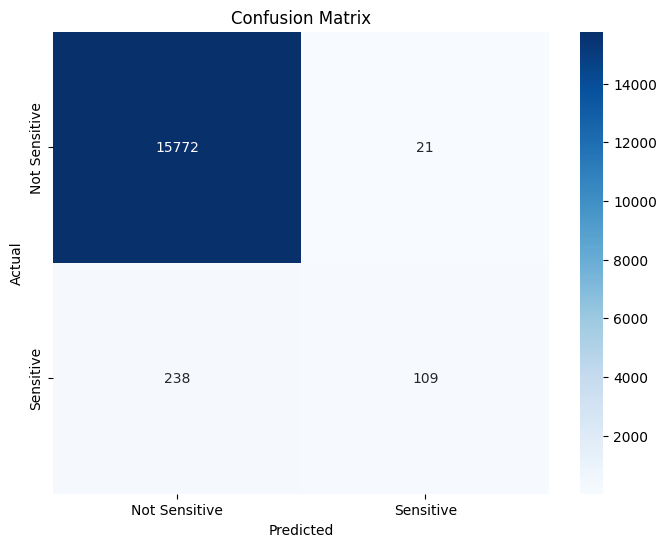

Accuracy: 0.9840
Precision: 0.8385
Recall: 0.3141
F1-score: 0.4570
F2-score: 0.3590


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Training of the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Sensitive', 'Sensitive'],
            yticklabels=['Not Sensitive', 'Sensitive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") # sensitivity
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")

Optimizing the threshold

In [32]:
# Grid search
thresholds = np.arange(0, 1, 0.01)
best_f1, best_threshold = 0, 0
for t in thresholds:
    y_pred_threshold = (model.predict_proba(X_validation)[:, 1] >= t).astype(int)
    score = f1_score(y_validation, y_pred_threshold)
    if score > best_f1:
        best_f1, best_threshold = score, t

print(f"Best F1: {best_f1:.4f} at threshold {best_threshold}")

Best F1: 0.5103 at threshold 0.08


Applying the best threshold to the original model

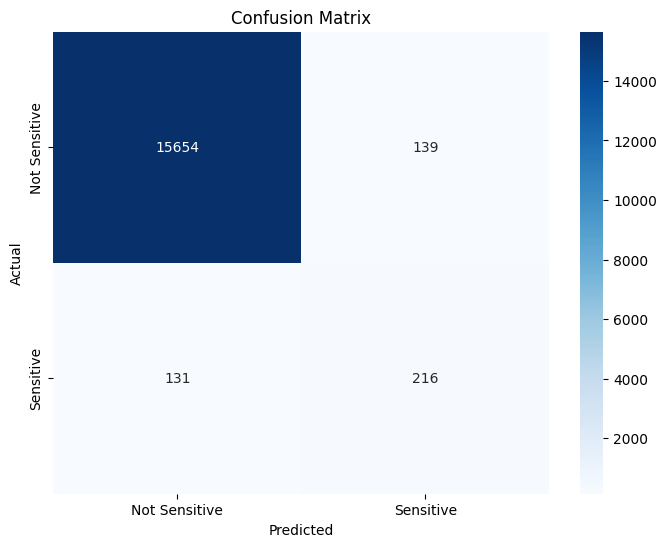

Accuracy: 0.9833
Precision: 0.6085
Recall: 0.6225
F1-score: 0.6154
F2-score: 0.6196


In [33]:
# New threshold
y_pred_test = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

# Evaluation
cm2 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Sensitive', 'Sensitive'],
            yticklabels=['Not Sensitive', 'Sensitive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy_2 = accuracy_score(y_test, y_pred_test)
precision_2 = precision_score(y_test, y_pred_test)
recall_2 = recall_score(y_test, y_pred_test)
f1_2 = f1_score(y_test, y_pred_test)
f2_2 = fbeta_score(y_test, y_pred_test, beta=2)


print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}") # sensitivity
print(f"F1-score: {f1_2:.4f}")
print(f"F2-score: {f2_2:.4f}")